# Tensor Regression Networks with ``TensorLy`` and ``PyTorch`` as a backend

In this notebook, we will show how to combine TensorLy and PyTorch in to implement the tensor regression layer, as defined in **Tensor Regression Networks**, _Jean Kossaifi, Zachary C. Lipton, Aran Khanna, Tommaso Furlanello and Anima Anandkumar_, [ArXiV pre-publication](https://arxiv.org/abs/1707.08308).


Specifically, we use [TensorLy](http://tensorly.org/dev/index.html) for the tensor operations, with the [PyTorch](http://pytorch.org/) backend.
You will need PyTorch version '0.4.0' or later to run this code.

We demonstrate the method on the MNIST dataset, which consists of images of digits between 0 and 9 (60,000 images for for training and 10,000 for testing). The task is to predict, given an image, which digit it represents.

# Tensor Regression Layers

Traditional Deep Convolutional Neural Networks consist of a series of convolutions, non-linearities and pooling, that result in an activation tensor. That activation tensor is typically passed on to a flattening layer and one or several fully-connected layers generate the outputs. 

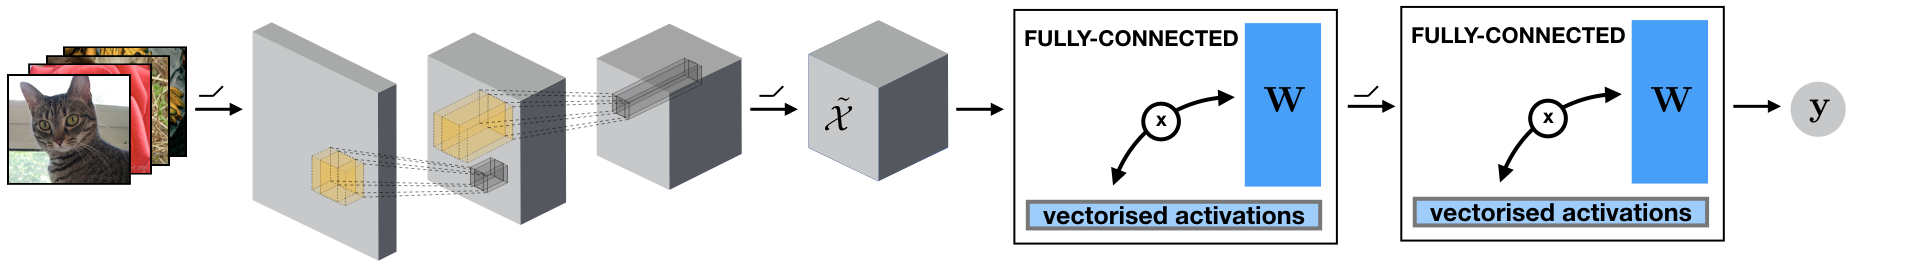

In [1]:
from IPython.display import Image, display
display(Image(filename='./images/FC.png', embed=True))

For instance, a typical architecture would be defined, in PyTorch as follows:

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
```

The idea of tensor regression layers is to instead leverage the spatial structure in the activation tensor
and formulate the output as lying in a low-rank subspace that jointly models the input and the output. This is done by means of a low-rank tensor regression.

The architecture corresponding to the previous one would be similar except that the Flatten layer and all fully-connected layers have been replaced by a Tensor Regression Layer:

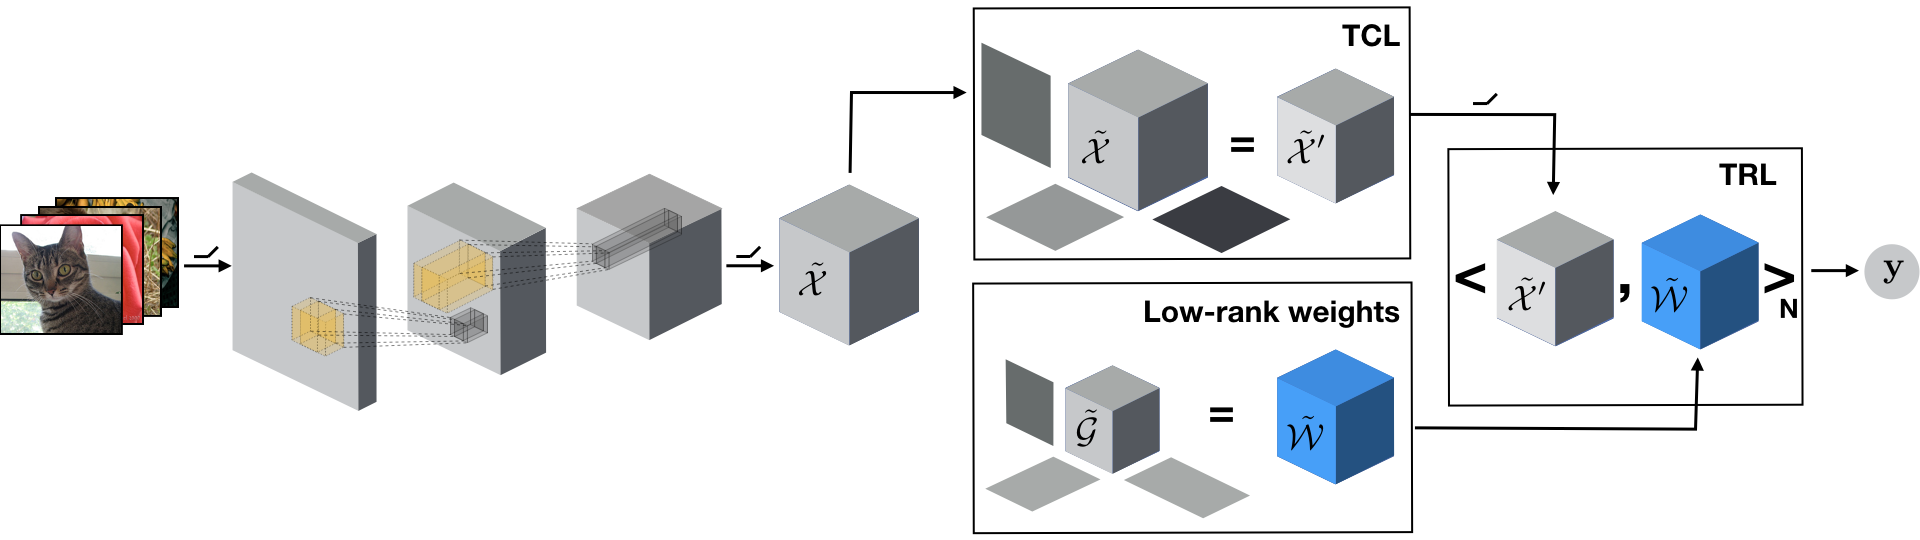

In [2]:
display(Image(filename='./images/TRL.png', embed=True))

In code, this would look something like this:

```python

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.trl = TRL(ranks=(10, 3, 3, 10), input_size=(batch_size, 50, 4, 4), output_size=(batch_size,10))

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.trl(x)
        return F.log_softmax(x)
```

In this notebook, we will demonstrate how to implement easily the TRL using TensorLy and MXNet.

# Implementation with TensorLy and PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np

import tensorly as tl
from tensorly.tenalg import inner
from tensorly.random import check_random_state

Using numpy backend.


Import TensorLy and set the backend to PyTorch:

In [2]:
import tensorly as tl
tl.set_backend('pytorch')

Using pytorch backend.


Parameters of the experiment:

In [3]:
batch_size = 16
device = 'cpu'
# to run on GPU, uncomment the following line:
#device = 'cuda:0'

Let us load the MNIST dataset. The following code will automatically download the data in a `data` folder if it hasn't already been done.

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


## Define the Tensor Regression Layer as a PyTorch layer

We wrap the code needed to perform low-rank tensor regression into a layer so we can connect it to a deep convolutional net.

In [5]:
class TRL(nn.Module):
    def __init__(self, input_size, ranks, output_size, verbose=1, **kwargs):
        super(TRL, self).__init__(**kwargs)
        self.ranks = list(ranks)
        self.verbose = verbose

        if isinstance(output_size, int):
            self.input_size = [input_size]
        else:
            self.input_size = list(input_size)
            
        if isinstance(output_size, int):
            self.output_size = [output_size]
        else:
            self.output_size = list(output_size)
            
        self.n_outputs = int(np.prod(output_size[1:]))
        
        # Core of the regression tensor weights
        self.core = nn.Parameter(tl.zeros(self.ranks), requires_grad=True)
        self.bias = nn.Parameter(tl.zeros(1), requires_grad=True)
        weight_size = list(self.input_size[1:]) + list(self.output_size[1:])
        
        # Add and register the factors
        self.factors = []
        for index, (in_size, rank) in enumerate(zip(weight_size, ranks)):
            self.factors.append(nn.Parameter(tl.zeros((in_size, rank)), requires_grad=True))
            self.register_parameter('factor_{}'.format(index), self.factors[index])
        
        # FIX THIS
        self.core.data.uniform_(-0.1, 0.1)
        for f in self.factors:
            f.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        regression_weights = tl.tucker_to_tensor(self.core, self.factors)
        return inner(x, regression_weights, n_modes=tl.ndim(x)-1) + self.bias
    
    def penalty(self, order=2):
        penalty = tl.norm(self.core, order)
        for f in self.factors:
            penatly = penalty + tl.norm(f, order)
        return penalty


# Define the net

Our network will be composed of a series of two convolutions, pooling, non-linearity.
Instead of using a flattening layer followed by a fully-connected layer, we will use our newly defined low-rank Tensor Regression Layer:

In [6]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.trl = TRL(ranks=(10, 3, 3, 10), input_size=(batch_size, 50, 4, 4), output_size=(batch_size,10))

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.trl(x)
        return F.log_softmax(x)


model = Net()


As previously, we define the optimiser to be an SGD an define the criterion to optimise.

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion=nn.CrossEntropyLoss()

Finally, the training loop. Notice the penalty on the regression weights added to the loss.

In [8]:
n_epoch = 5 # Number of epochs
regularizer = 0.001

model = model.to(device)

def train(n_epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Important: do not forget to reset the gradients
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output,target) + regularizer*model.trl.penalty(2)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss = criterion(output,target)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('mean: {}'.format(test_loss))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))


for epoch in range(n_epoch):
    train(epoch)
    test()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304229
Train Epoch: 0 [16000/60000 (27%)]	Loss: 2.304027
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.487699
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.011045
mean: 7.119077963579912e-06

Test set: Average loss: 0.0000, Accuracy: 9674/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.093622
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.009206
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.011847
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.061825
mean: 1.3250013353172108e-06

Test set: Average loss: 0.0000, Accuracy: 9859/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.110160
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.083061
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.048869
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.005587
mean: 3.680340512346447e-07

Test set: Average loss: 0.0000, Accuracy: 9848/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.006312
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.313510
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.255003
Tr